*Josh Albano, Sharon Jan, and Luke Sherman*

*2020.5.8*

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from pandas.plotting import register_matplotlib_converters

from sklearn.linear_model import LinearRegression

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import re




from IPython.display import display, Latex, Markdown

#  Research plan?

### Research Question: Can counties' responses to COVID-19 accurately predict various political features?

Workplan:
- Clean data
    - Remove US territories (Sharon)
    - 
- Define political features
    - Republican/Democratic governor (binary) (Sharon)
    - Joshua's R/D scale (categorical) (Josh)
    - % of counties that are Republican (Sharon)
- Define potential COVID-19 features
    - Google's mobility rating (Josh)
    - Date of stay at home orders, relative to a case threshold (Luke)
        - Should we transform the case threshold to per capita
    - "Performance" - Beta_2 for quadratic model (Luke)
- Create model(s)
- Data visualizations

# EDA
## Taking a look at the dataset



In [2]:
# Looking at the data

states_df = pd.read_csv("4.18states.csv")


In [3]:
counties_df = pd.read_csv("abridged_couties.csv")
# Added to get rid of U.S. territories - Sharon
counties_df = counties_df[counties_df['State'].notna()]

In [4]:
time_cases_df = pd.read_csv("time_series_covid19_confirmed_US.csv")

In [5]:
time_deaths_df = pd.read_csv("time_series_covid19_deaths_US.csv")

# Let's look at the basics

Let's look at the distribution of stay at home orders by county:

Text(0.5, 1.0, 'Distribution of stay at home orders by US county')

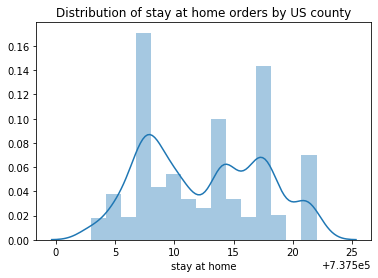

In [6]:
sns.distplot(counties_df["stay at home"].dropna())

plt.title("Distribution of stay at home orders by US county")

Now, let's look at the times series of cases.

Text(0.5, 1.0, 'Cumuative cases since Feb')

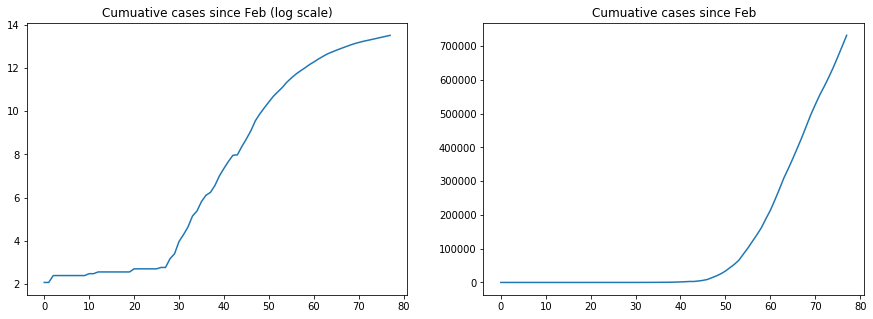

In [7]:
us = time_cases_df.groupby("Country_Region").sum().iloc[:,15:].to_numpy().flatten()

fig, ax = plt.subplots(1,2, figsize=(15,5))

ax[0].plot(np.arange(0,len(us)), np.log(us))

ax[0].set_title("Cumuative cases since Feb (log scale)")

ax[1].plot(np.arange(0,len(us)), us)

ax[1].set_title("Cumuative cases since Feb")

<BarContainer object of 77 artists>

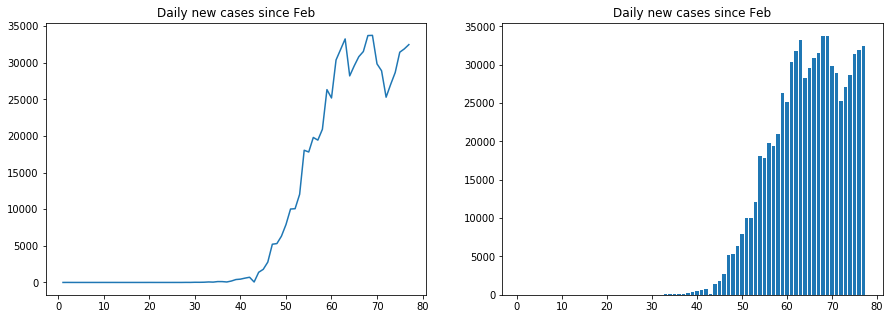

In [8]:
fig, ax = plt.subplots(1,2, figsize=(15,5))

ax[0].plot(np.arange(1,len(us)), np.diff(us) )
ax[0].set_title("Daily new cases since Feb")
ax[1].set_title("Daily new cases since Feb")

ax[1].bar(np.arange(1,len(us)), np.diff(us) )

## Addressing the date time conversion on time series data

Let's look at the dates related to stay at home orders:

In [9]:
# The date objects were extremely annoying, so I built this function to convert them to pandas

def convert_ordinal_date_series_to_pd_date(series_object):
    """
    This function takes a series object of ordinal dates (days from the beginning of the 
    Gregorian calendar) and returns a pandas date time object series
    """
    
    #series_object = series_object.astype(int)
    
    k = []
    y = 0
    
    for ordinal_date in series_object:
        if np.isnan(ordinal_date) == True:
            y += 1
            k.append(np.nan)
            
        else:
            ordinal_date = int(ordinal_date)
            k.append(pd.to_datetime(datetime.datetime.fromordinal(ordinal_date)))
    print("Your series has", y, "NaNs. This function converts them to NaTs.")
    return pd.Series(k, index = series_object.index)

In [10]:
# Let's test this function
# Alameda closed on March 17. Let's see if we can get that

index = counties_df[counties_df["CountyName"] == "Alameda"]["stay at home"].index
print("\n Date Alameda County closed:",convert_ordinal_date_series_to_pd_date(counties_df["stay at home"])[index].iloc[0])


# okay so this is interesting. This dataset only includes the state shutdowns orders, even though it
# seems to be at the county level...


#print("\n", counties_df[counties_df["StateName"]=="CA"]["stay at home"])


print("\n This shows that all the counties had stay at home orders on the same day, even though Alameda issued a county order earlier")

print("\n Anyway, the function works and gets the date converstion right.")

Your series has 490 NaNs. This function converts them to NaTs.

 Date Alameda County closed: 2020-03-19 00:00:00

 This shows that all the counties had stay at home orders on the same day, even though Alameda issued a county order earlier

 Anyway, the function works and gets the date converstion right.


## Characterizing regional covid curves

Now I'm going to do a very simply time series model that can describe the curve for any geogrpahic location:


$new.cases = \beta_0 + \beta_1~time + \beta_2~time^2$

Or actually, it may be more appropriate to do this without an intercept:

$new.cases = \beta_1~time + \beta_2~time^2$

In this functional form, it easy to interpret $\beta_2$ as the deceleration rate. We can calculate state by state deceleration rates.
 

**We can we try to use the decelerration rates to classify whether a state is democrat or republican?**

### Creating a function to output betas

In [11]:
#county = 12086

In [12]:
def quadratic_time_series_model_daily_cases(county, threshold=300, min_observation_days=15, plot=False, intercept=False):
    """
    Function to get beta values for a quadratic time series model.
    Use county variable to specify the FIPS code for the relevant region. 
    Threshold is a scalar for the total number of cases in a region before beginning the model.
    Has an option to generate a basic plot when plot = True.
    Minimum observation days sets a minimum number of days since the threshold case value was reached to calculate the model.
    If the minimum observation days are not met, the function returns a list of nans.
    
    Returns a list of intercept, beta_1, and beta_2 in the model below
    
    daily_new_cases = beta_0 + beta_1*days_since_threshold_cases + beta_2*days_since_threshold_cases^2
    """

    pd.set_option('mode.chained_assignment', None)

    ids = ["FIPS","Admin2", "Province_State", "Country_Region"]

    date_column_begin = 11

    df = time_cases_df[ids + list(time_cases_df.columns[date_column_begin:])]

    df = df[-df["FIPS"].isna()] #drop cases with no FIPS ID

    df = df.melt(ids).rename(columns = {"value" : "cases"})

    date = pd.to_datetime(df["variable"], format="%m/%d/%y")

    df["date"] = date

    county_df = df.pivot_table(values = "cases", index = [ "FIPS", "date", "Admin2", "Province_State"],  aggfunc=sum).reset_index()

    county_df = county_df[county_df["FIPS"]==county]

    county_df

    zero = np.array([0])

    new_cases_array = np.concatenate([zero, np.diff(county_df["cases"])])

    county_df.loc[:,"daily_new_cases"] = (new_cases_array) #Error here: A value is trying to be set on a copy of a slice from a DataFrame

    county_df = county_df[county_df["cases"] >= threshold]
    

    if len(county_df) < min_observation_days:
        return [np.nan, np.nan, np.nan]
    else:
    
        county_df["days_since_threshold"] = np.arange(0,len(county_df))

        county_df["days_since_threshold^2"] = county_df["days_since_threshold"]**2


        lm = LinearRegression(fit_intercept=intercept)

        x = county_df[["days_since_threshold","days_since_threshold^2"]]

        y = np.array(county_df["daily_new_cases"]).reshape(-1,1)

        lm.fit(x,y)

        if plot == True:
            y_hat = lm.predict(x)
            plt.plot(county_df["days_since_threshold"], (county_df["daily_new_cases"]))
            plt.plot(county_df["days_since_threshold"], y_hat)

            plot_title_string = county_df["Admin2"].iloc[0] + ", " + county_df["Province_State"].iloc[0] + " FIPS: " + str(int(county_df["FIPS"].iloc[0]))
            plt.title("Quadratic modeling of daily cases for {}".format(plot_title_string))
            plt.ylabel("Daily new cases")
            plt.xlabel("days since {} cases".format(threshold))

        if intercept == True:
            return [lm.intercept_[0], lm.coef_[0][0], lm.coef_[0][1]]
        else:
            return [0, lm.coef_[0][0], lm.coef_[0][1]]

[0, 61.05213465041337, -2.048483256270142]

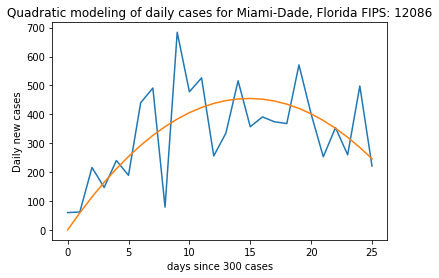

In [13]:
t = quadratic_time_series_model_daily_cases(12086, plot = True)
t

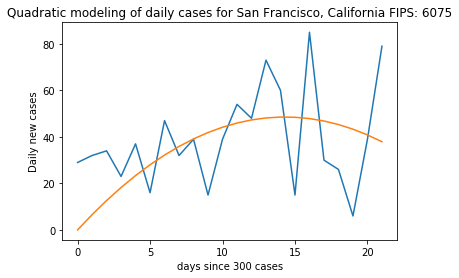

In [14]:
t = quadratic_time_series_model_daily_cases(6075, plot = True)

Note how different a shape we get on San Francisco County depending on whether the intercept is included  or not.

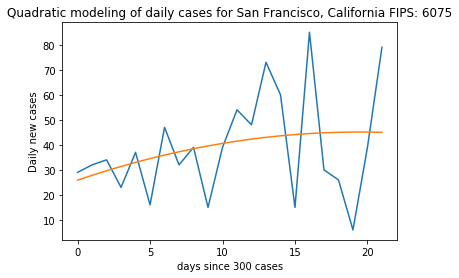

In [15]:
t = quadratic_time_series_model_daily_cases(6075, plot = True, intercept=True)

In [13]:
def quadratic_time_series_model_daily_cases_state(state, threshold=300, min_observation_days=15, plot=False,intercept=False):
    """
    Function to get beta values for a quadratic time series model.
    Use county variable to specify the FIPS code for the relevant region. 
    Threshold is a scalar for the total number of cases in a region before beginning the model.
    Has an option to generate a basic plot when plot = True.
    Minimum observation days sets a minimum number of days since the threshold case value was reached to calculate the model.
    If the minimum observation days are not met, the function returns a list of nans.
    
    Returns a list of intercept, beta_1, and beta_2 in the model below
    
    daily_new_cases = beta_0 + beta_1*days_since_threshold_cases + beta_2*days_since_threshold_cases^2
   """
    
    pd.set_option('mode.chained_assignment', None)

    ids = ["FIPS","Admin2", "Province_State", "Country_Region"]

    date_column_begin = 11

    df = time_cases_df[ids + list(time_cases_df.columns[date_column_begin:])]

    df = df.melt(ids).rename(columns = {"value" : "cases"})


    date = pd.to_datetime(df["variable"], format="%m/%d/%y")

    df["date"] = date


    county_df = df.pivot_table(values = "cases", index = [ "Province_State", "date"],  aggfunc=sum).reset_index()


    county_df = county_df[county_df["Province_State"] == state]

    zero = np.array([0])

    new_cases_array = np.concatenate([zero, np.diff(county_df["cases"])])

    county_df.loc[:,"daily_new_cases"] = (new_cases_array) #Error here: A value is trying to be set on a copy of a slice from a DataFrame


    county_df = county_df[county_df["cases"] >= threshold]
        
    if len(county_df) < min_observation_days:
        return [np.nan, np.nan, np.nan]
    else:
    
        county_df["days_since_threshold"] = np.arange(0,len(county_df))

        county_df["days_since_threshold^2"] = county_df["days_since_threshold"]**2


        lm = LinearRegression(fit_intercept = intercept)

        x = county_df[["days_since_threshold","days_since_threshold^2"]]

        y = np.array(county_df["daily_new_cases"]).reshape(-1,1)

        lm.fit(x,y)

        if plot == True:
            y_hat = lm.predict(x)
            plt.plot(county_df["days_since_threshold"], (county_df["daily_new_cases"]))
            plt.plot(county_df["days_since_threshold"], y_hat)

            plot_title_string = county_df["Province_State"].iloc[0]
            plt.title("Quadratic modeling of daily cases for {}".format(plot_title_string))
            plt.ylabel("Daily new cases")
            plt.xlabel("days since {} cases".format(threshold))

        if intercept == True:
            return [lm.intercept_[0], lm.coef_[0][0], lm.coef_[0][1]]
        else:
            return [0, lm.coef_[0][0], lm.coef_[0][1]]

[-167.83001422475104, 93.06162186069307, -1.500800889345781]

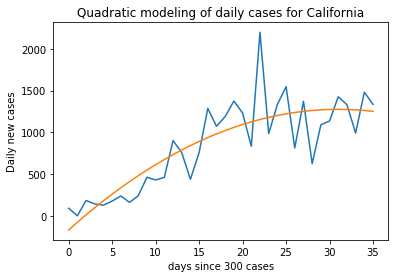

In [14]:
quadratic_time_series_model_daily_cases_state("California", plot=True, intercept=True)

[0, 74.15744786287604, -1.0570409363453805]

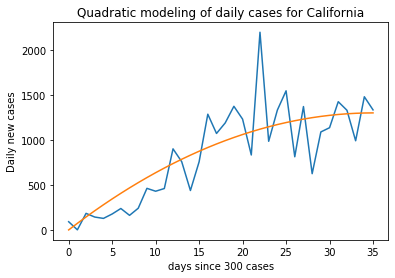

In [15]:
quadratic_time_series_model_daily_cases_state("California", plot=True, intercept=False)

[0, 40.811513837455465, -0.9750295030913635]

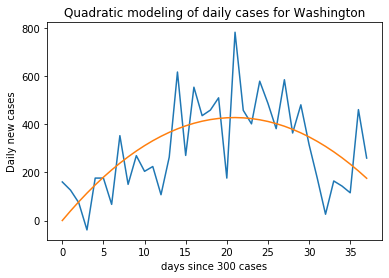

In [16]:
quadratic_time_series_model_daily_cases_state("Washington", plot=True, intercept=False)

[-12.88866396761108, 42.18589743589741, -1.0055713608345183]

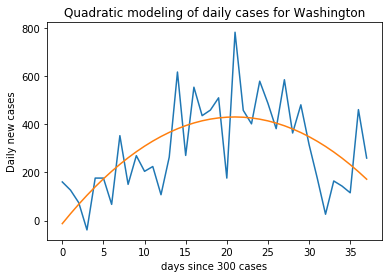

In [17]:
quadratic_time_series_model_daily_cases_state("Washington", plot=True, intercept=True)

In [18]:
#Implementing this function in a for loop is too slow, so I need to make  another function.

In [19]:
def create_state_beta_table(threshold=300, min_observation_days=15, intercept=False):
    pd.set_option('mode.chained_assignment', None)
    
    ids = ["FIPS","Admin2", "Province_State", "Country_Region"]

    date_column_begin = 11

    df = time_cases_df[ids + list(time_cases_df.columns[date_column_begin:])]
    
    df = df[-df["FIPS"].isna()] #drop cases with no FIPS ID
    
    df = df.melt(ids).rename(columns = {"value" : "cases"})

    date = pd.to_datetime(df["variable"], format="%m/%d/%y")

    df["date"] = date
    
    df = df.pivot_table(values = "cases", index = [ "Province_State", "date"],  aggfunc=sum).reset_index()
    
    zero = np.array([0])
    
    k = []
    
    for state in np.unique(time_cases_df["Province_State"]):
        
        county_df = df[df["Province_State"] == state]

        zero = np.array([0])

        new_cases_array = np.concatenate([zero, np.diff(county_df["cases"])])

        county_df.loc[:,"daily_new_cases"] = (new_cases_array) #Error here: A value is trying to be set on a copy of a slice from a DataFrame


        county_df = county_df[county_df["cases"] >= threshold]

        if len(county_df) < min_observation_days:
            k.append([np.nan, np.nan, np.nan])
            
        else:
            county_df["days_since_threshold"] = np.arange(0,len(county_df))

            county_df["days_since_threshold^2"] = county_df["days_since_threshold"]**2

            lm = LinearRegression()

            x = county_df[["days_since_threshold","days_since_threshold^2"]]

            y = np.array(county_df["daily_new_cases"]).reshape(-1,1)

            lm.fit(x,y)
            
            if intercept == True:
                k.append([lm.intercept_[0], lm.coef_[0][0], lm.coef_[0][1] ])
            else:
                k.append([0, lm.coef_[0][0], lm.coef_[0][1] ])
        
    state_betas = pd.DataFrame(k).rename(columns = {0:"beta0",1:"beta1",2:"beta2"})
    state_betas.index = np.unique(time_cases_df["Province_State"])

    return(state_betas)

In [20]:
state_betas = create_state_beta_table()

state_betas
#create_state_beta_table(threshold=200, min_observation_days=30)

,beta0,beta1,beta2
Alabama,0.0,16.407425,-0.432553
Alaska,NaN,NaN,NaN
American Samoa,NaN,NaN,NaN
Arizona,0.0,8.568596,-0.228816
Arkansas,0.0,4.649976,-0.133855
California,0.0,93.061622,-1.500801
Colorado,0.0,32.468041,-0.852440
Connecticut,0.0,69.941981,-1.345922
Delaware,0.0,10.436075,-0.202492
Diamond Princess,NaN,NaN,NaN


In [24]:
def create_county_beta_table(threshold=300, min_observation_days=15, intercept=False):
    pd.set_option('mode.chained_assignment', None)
    
    ids = ["FIPS","Admin2", "Province_State", "Country_Region"]

    date_column_begin = 11

    df = time_cases_df[ids + list(time_cases_df.columns[date_column_begin:])]
    
    df = df[-df["FIPS"].isna()] #drop cases with no FIPS ID
    
    df = df.melt(ids).rename(columns = {"value" : "cases"})

    date = pd.to_datetime(df["variable"], format="%m/%d/%y")

    df["date"] = date
    
    df = df.pivot_table(values = "cases", index = [ "FIPS", "date", "Admin2", "Province_State"],  aggfunc=sum).reset_index()
    
    zero = np.array([0])
    
    k = []
    
    for county in np.unique(time_cases_df["FIPS"]):
        
        county_df = df[df["FIPS"]==county]
        
        new_cases_array = np.concatenate([zero, np.diff(county_df["cases"])])
        
        county_df.loc[:,"daily_new_cases"] = (new_cases_array) #Error here: A value is trying to be set on a copy of a slice from a DataFrame

        county_df = county_df[county_df["cases"] >= threshold]
        
        if len(county_df) < min_observation_days:
            k.append([np.nan, np.nan, np.nan])
        else:
            county_df["days_since_threshold"] = np.arange(0,len(county_df))

            county_df["days_since_threshold^2"] = county_df["days_since_threshold"]**2


            lm = LinearRegression(fit_intercept=intercept)

            x = county_df[["days_since_threshold","days_since_threshold^2"]]

            y = np.array(county_df["daily_new_cases"]).reshape(-1,1)

            lm.fit(x,y)
            
            if intercept == True:
                k.append([lm.intercept_[0], lm.coef_[0][0], lm.coef_[0][1] ])
            else:
                k.append([0, lm.coef_[0][0], lm.coef_[0][1] ])
            
    county_betas = pd.DataFrame(k).rename(columns = {0:"beta0",1:"beta1",2:"beta2"})
    county_betas.index = np.unique(time_cases_df["FIPS"])
    
    return county_betas



In [21]:
#create_county_beta_table(min_observation_days=15).dropna()

create_county_beta_table(min_observation_days=20).dropna()

NameError: name 'create_county_beta_table' is not defined

[0, 97.96665413253565, -2.6170889408151394]

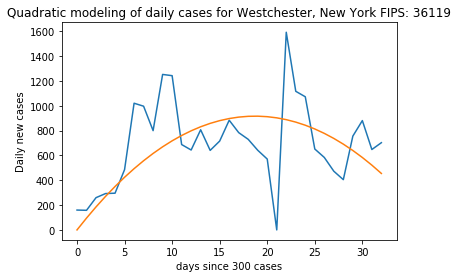

In [22]:
quadratic_time_series_model_daily_cases(36119, plot = True)

[123.12280701754386, 1.6767285861713104, -0.33823529411764713]

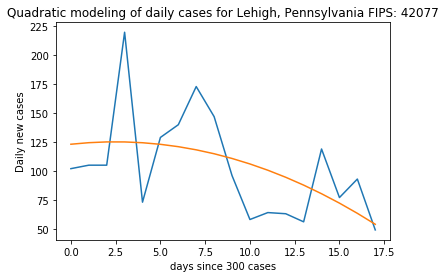

In [23]:
quadratic_time_series_model_daily_cases(42077, plot = True, intercept=True)

[0, 29.780847579306307, -1.6765266747431233]

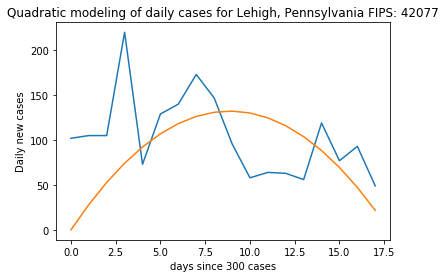

In [24]:
quadratic_time_series_model_daily_cases(42077, plot = True)

Now, let's see if the shape of these curves tells us anything at all about the governors of each state

In [25]:
govs = pd.read_csv("state-governors.csv")



govs.columns=govs.loc[0]
column_numbers = [x for x in range(govs.shape[1])]  # list of columns' integer indices
column_numbers.remove(3) #removing column integer index 0
govs = govs.iloc[:, column_numbers] 
govs = govs.drop(0, axis=0).rename(columns = {"Party":"Governor's Party"})

govs.loc[23,"Governor's Party"] = "Democratic"
govs.loc[48,"Governor's Party"] = "Republican"

print(govs.groupby("Governor's Party").count()["State"])

Governor's Party
Democratic    24
Republican    26
Name: State, dtype: int64


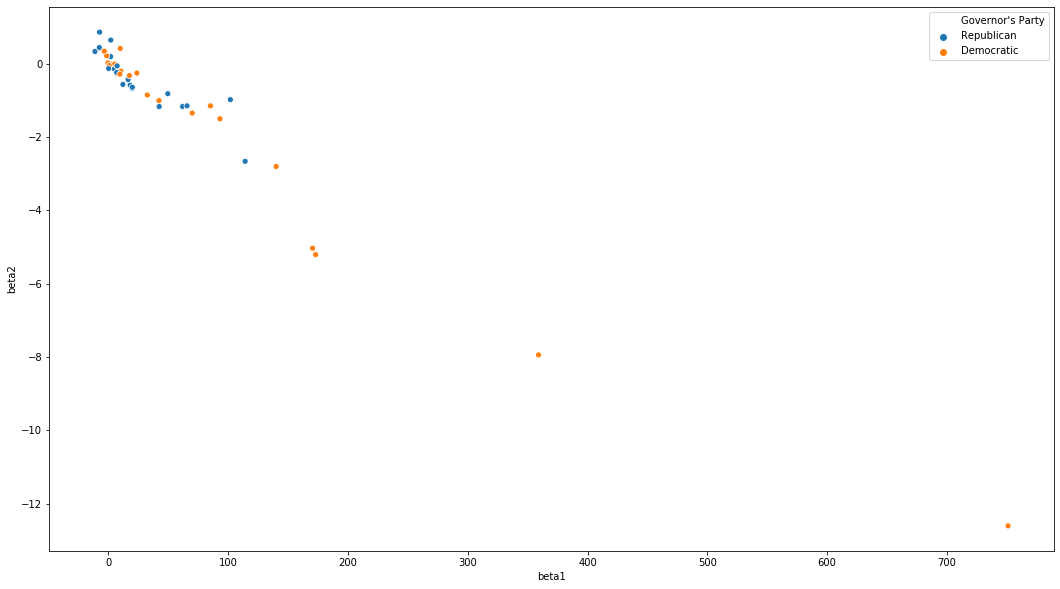

In [26]:
data = pd.merge(govs, state_betas, left_on = "State", right_index=True)

fig,ax = plt.subplots(figsize=(18,10))

g=sns.scatterplot(x = "beta1", y="beta2", hue= "Governor's Party", data = data)

#g.set(xlim=(0,20))

Looks like this was pretty much a lost cause....

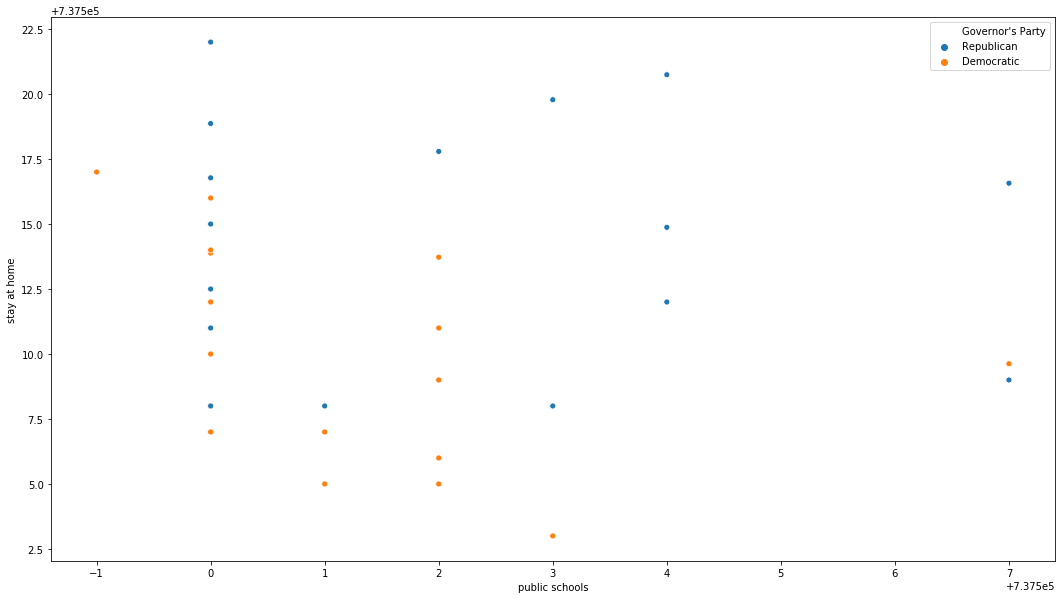

In [27]:
state_vars_grouped = counties_df.groupby("State").mean()

data = pd.merge(state_vars_grouped, govs, left_on = "State", right_on="State")

fig,ax = plt.subplots(figsize=(18,10))

g=sns.scatterplot(x = "public schools", y="stay at home", hue= "Governor's Party", data = data)

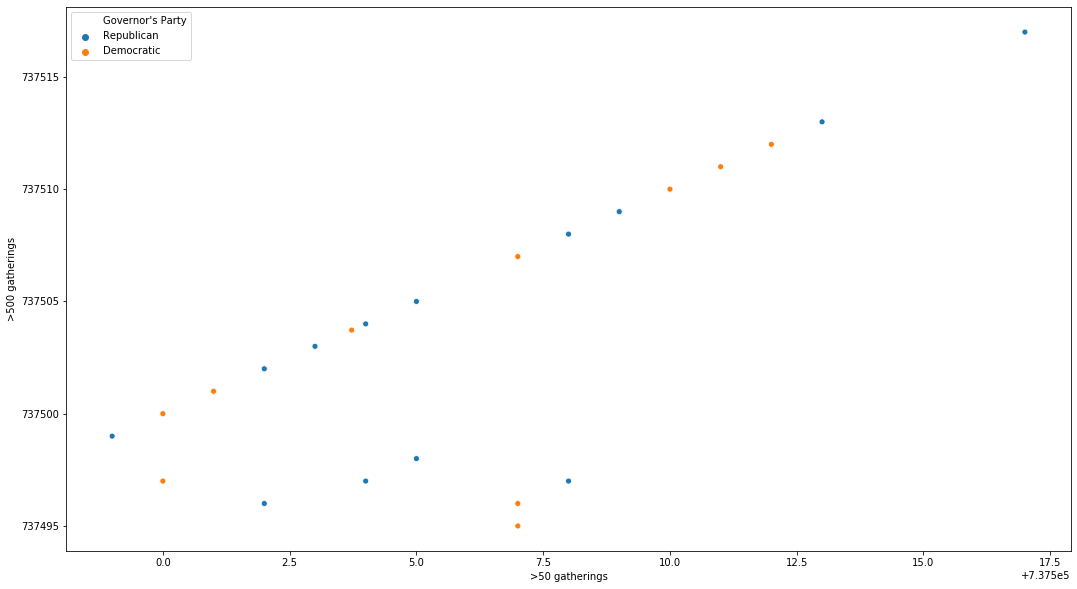

In [28]:
fig,ax = plt.subplots(figsize=(18,10))

g=sns.scatterplot(x = ">50 gatherings", y=">500 gatherings", hue= "Governor's Party", data = data)

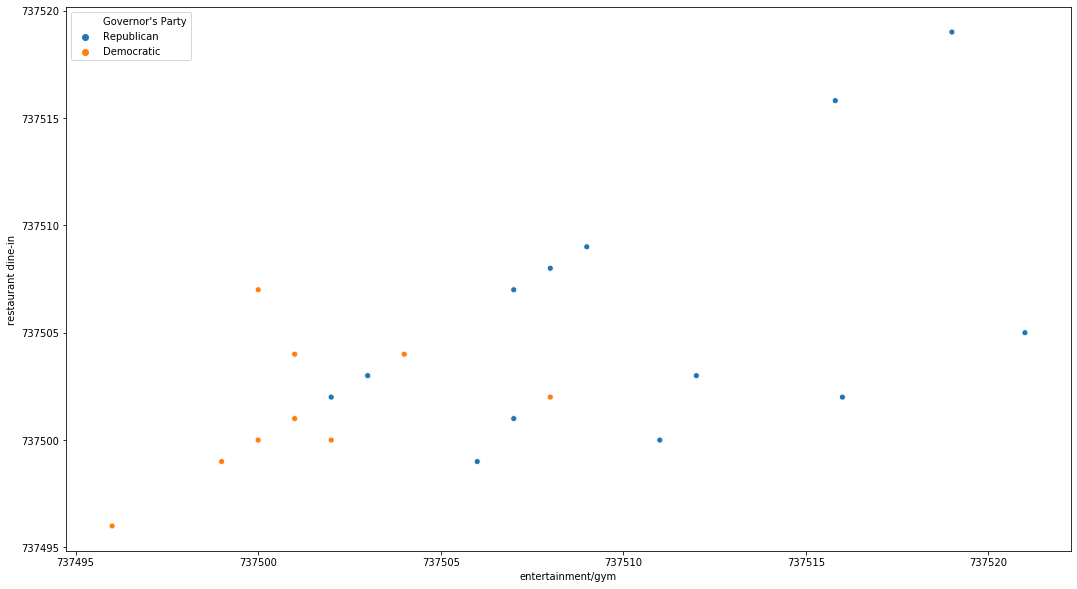

In [29]:
fig,ax = plt.subplots(figsize=(18,10))

g=sns.scatterplot(x = "entertainment/gym", y="restaurant dine-in", hue= "Governor's Party", data = data)

In [30]:
data = pd.merge(states_df, govs, left_on = "Province_State", right_on="State")

data.columns

Index([         'Province_State',          'Country_Region',
                   'Last_Update',                     'Lat',
                         'Long_',               'Confirmed',
                        'Deaths',               'Recovered',
                        'Active',                    'FIPS',
                 'Incident_Rate',           'People_Tested',
           'People_Hospitalized',          'Mortality_Rate',
                           'UID',                    'ISO3',
                  'Testing_Rate',    'Hospitalization_Rate',
                         'State',                'Portrait',
                      'Governor',        'Governor's Party',
                          'Born', 'Prior public experience',
                  'Inauguration',             'End of term',
                'Past governors',                       nan],
      dtype='object')

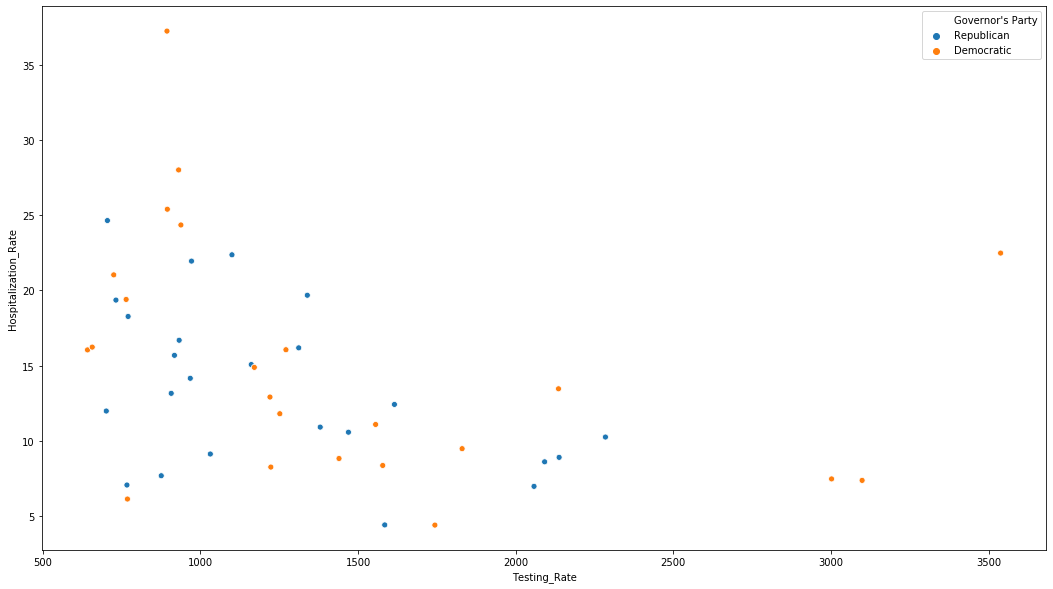

In [31]:
fig,ax = plt.subplots(figsize=(18,10))

g=sns.scatterplot(x = "Testing_Rate", y="Hospitalization_Rate", hue= "Governor's Party", data = data)

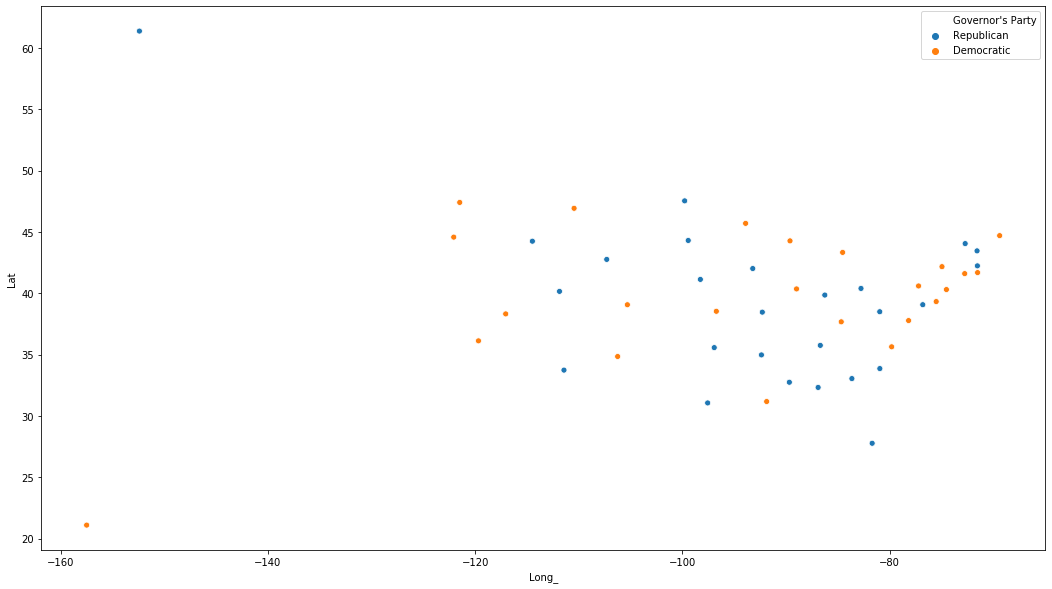

In [32]:
fig,ax = plt.subplots(figsize=(18,10))

g=sns.scatterplot(x = "Long_", y="Lat", hue= "Governor's Party", data = data)

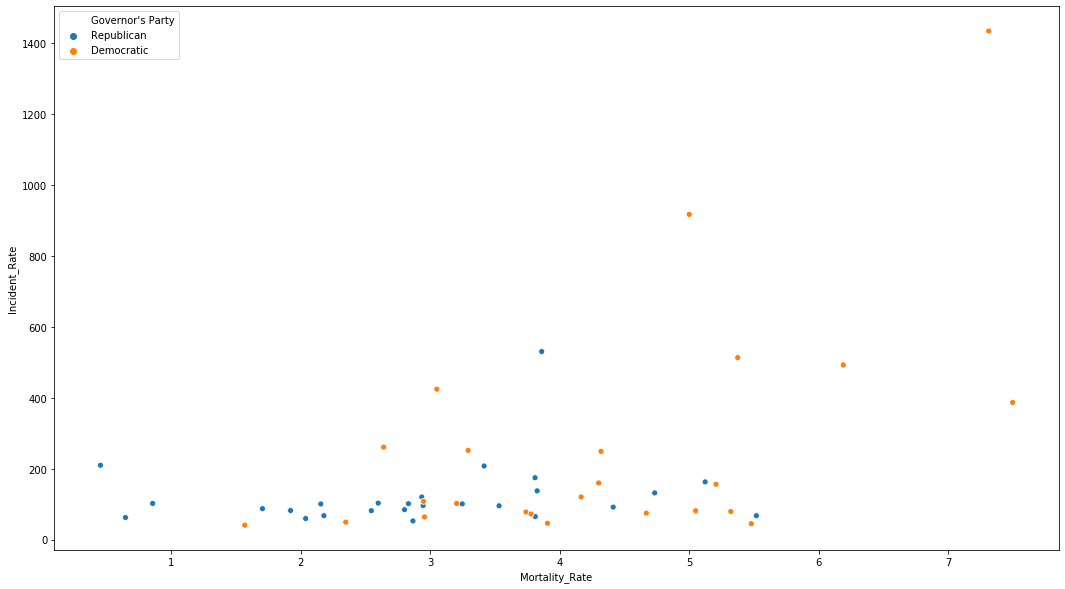

In [33]:
fig,ax = plt.subplots(figsize=(18,10))

g=sns.scatterplot(x = "Mortality_Rate", y="Incident_Rate", hue= "Governor's Party", data = data)

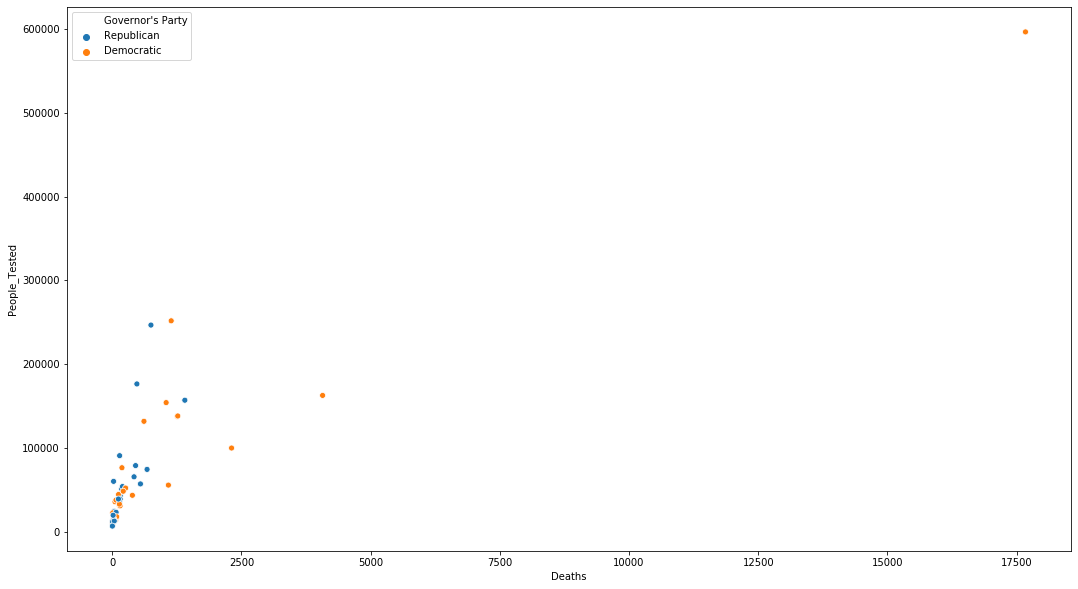

In [34]:
fig,ax = plt.subplots(figsize=(18,10))

g=sns.scatterplot(x = "Deaths", y="People_Tested", hue= "Governor's Party", data = data)

# Calculating R

The issue with the quadratic model is that it really just shows the intensity of the outbreaks, not the true rate of transmission. This is because it has the incorrect functional form. Disease outbreaks should be modeled as exponentials. Epidimiologists use the Reproductive Rate $R$ to describe disease outbreaks.

I'm going to now build a function to estimate R so that we can use it as a parameter in our models.

More information here:

https://en.wikipedia.org/wiki/Basic_reproduction_number

$R_0=e^{K~\tau}$

$K = \cfrac{d~ ln(N(t))}{dt}$

$\tau = \text{the serial interval}$

$N(t) = \text{an exponential time series for the number of cases over time (t}$


***

$N(t) = e^{kt}$

$ln(N(t)) = ln(e^{kt})$


***

$ln(N(t)) = kt*ln(e)$

$ln(N(t)) = kt$

$\frac{d}{dt}ln(N(t)) = k$




Let's estimate $R_0$ based off only the last 3 weeks (21 days). The reasoning for this is that a variety of factors related to behavioral and political intervention should have a differential effect on R. In the early stages of this outbreak, we might expect less consistent efforts.

In [35]:
def calculate_R(state_or_FIPS, start_date=67, end_date=88, serial_interval = 10, min_obs=15):
    """
    calculates R value using either State names (must be strings) or FIPS codes (must be numeric). 
    Altetantively, input a Pandas Series object of state strings or FIPS codes.
    
    Specify time series start date and end date over the period day 0 to day 88
    
    Serial interval is the time lag (in days) for the spread of the disease
    
    min obs is a minimum number of observed case reporting days for each instance
    
    Returns the basic reproductive number R, and the associated K
    
    LaTeX FORMULAS
    
    $R_0=e^{K~\tau}$

    $K = \cfrac{d~ ln(N(t))}{dt}$

    $\tau = \text{the serial interval}$

    $N(t) = \text{an exponential time series for the number of cases over time (t}$

    """

    pd.set_option('mode.chained_assignment', None)
    ids = ["FIPS","Admin2", "Province_State", "Country_Region"]

    date_column_begin = 11
    df = time_cases_df[ids + list(time_cases_df.columns[date_column_begin:])]
    df = df.melt(ids).rename(columns = {"value" : "cases"})
    date = pd.to_datetime(df["variable"], format="%m/%d/%y")
    df["date"] = date


    if isinstance(state_or_FIPS, pd.Series):
        j = []
       
        fips_table = df.pivot_table(values = "cases", index = ["FIPS", "date", "Province_State"],  aggfunc=sum).reset_index()
        
        
        for code in state_or_FIPS:
            #print(code)
            if isinstance(code, str):
                county_df = df.pivot_table(values = "cases", index = [ "Province_State", "date"],  aggfunc=sum).reset_index()
                county_df = county_df[county_df["Province_State"] == code]

            else:
                county_df = fips_table[fips_table["FIPS"] == code]
                

            zero = np.array([0])
            new_cases_array = np.concatenate([zero, np.diff(county_df["cases"])])
            county_df.loc[:,"daily_new_cases"] = (new_cases_array) #Error here: A value is trying to be set on a copy of a slice from a DataFram

            county_df = county_df.iloc[start_date:end_date+1]


            county_df["days"] = np.arange(0,len(county_df))


            county_df = county_df[county_df["daily_new_cases"] > 0]

            if len(county_df) < min_obs: #an in if statement here in case there are no cases
                j.append([np.nan,np.nan])

            else:

                lm = LinearRegression()

                x = np.array(county_df["days"]).reshape(-1,1)
                y = np.log(np.array(county_df["daily_new_cases"]).reshape(-1,1))
                lm.fit(x,y)

                K = lm.coef_[0]

                R = np.exp(lm.coef_[0] * serial_interval)

                j.append([R[0], K[0]])

        values = pd.DataFrame(j).rename(columns = {0:"R",1:"K"})
        values.index = state_or_FIPS
        return values


    elif isinstance(state_or_FIPS, str):
        county_df = df.pivot_table(values = "cases", index = [ "Province_State", "date"],  aggfunc=sum).reset_index()
        county_df = county_df[county_df["Province_State"] == state_or_FIPS]

    else:
        county_df = df.pivot_table(values = "cases", index = ["FIPS", "date", "Admin2", "Province_State"],  aggfunc=sum).reset_index()
        county_df = county_df[county_df["FIPS"] == state_or_FIPS]


    zero = np.array([0])
    new_cases_array = np.concatenate([zero, np.diff(county_df["cases"])])
    county_df.loc[:,"daily_new_cases"] = (new_cases_array) #Error here: A value is trying to be set on a copy of a slice from a DataFrame


    county_df = county_df.iloc[start_date:end_date+1]


    county_df["days"] = np.arange(0,len(county_df))


    county_df = county_df[county_df["daily_new_cases"] > 0]

        #an in if statement here in case there are no cases
    if len(county_df) < min_obs:
        return [np.nan, np.nan]
    else:

        lm = LinearRegression()

        x = np.array(county_df["days"]).reshape(-1,1)
        y = np.log(np.array(county_df["daily_new_cases"]).reshape(-1,1))
        lm.fit(x,y)

        K = lm.coef_

        R = np.exp(lm.coef_[0] * serial_interval)
    
        print("R,K for" ,state_or_FIPS)
        return R, K

In [1]:
calculate_R("California")

NameError: name 'calculate_R' is not defined

In [37]:
calculate_R("North Dakota")

R,K for North Dakota


(array([1.90136098]), array([[0.06425699]]))

In [41]:
calculate_R(6001)

R,K for 6001


(array([1.25559278]), array([[0.02276078]]))

In [42]:
states = pd.Series(np.unique(time_cases_df["Province_State"]))
Rs = calculate_R(states)
Rs

,R,K
Alabama,1.471058,0.038598
Alaska,0.747570,-0.029093
American Samoa,NaN,NaN
Arizona,0.985777,-0.001433
Arkansas,1.347915,0.029856
California,1.058416,0.005677
Colorado,1.358830,0.030662
Connecticut,1.448197,0.037032
Delaware,2.328676,0.084530
Diamond Princess,NaN,NaN


In [50]:
#this take a minute to run
county_Rs = calculate_R(time_cases_df["FIPS"]).dropna()

county_Rs

,R,K
FIPS,,
66.0,0.655929,-0.042170
72.0,0.894311,-0.011170
1003.0,1.576235,0.045504
1007.0,1.363250,0.030987
1015.0,0.766084,-0.026646
1017.0,1.004304,0.000429
1055.0,0.859351,-0.015158
1069.0,1.607103,0.047443
1073.0,0.702849,-0.035261


In [43]:
data = pd.merge(Rs, govs, left_index = True, right_on="State")

data.columns

Index([                      'R',                       'K',
                         'State',                'Portrait',
                      'Governor',        'Governor's Party',
                          'Born', 'Prior public experience',
                  'Inauguration',             'End of term',
                'Past governors',                       nan],
      dtype='object')

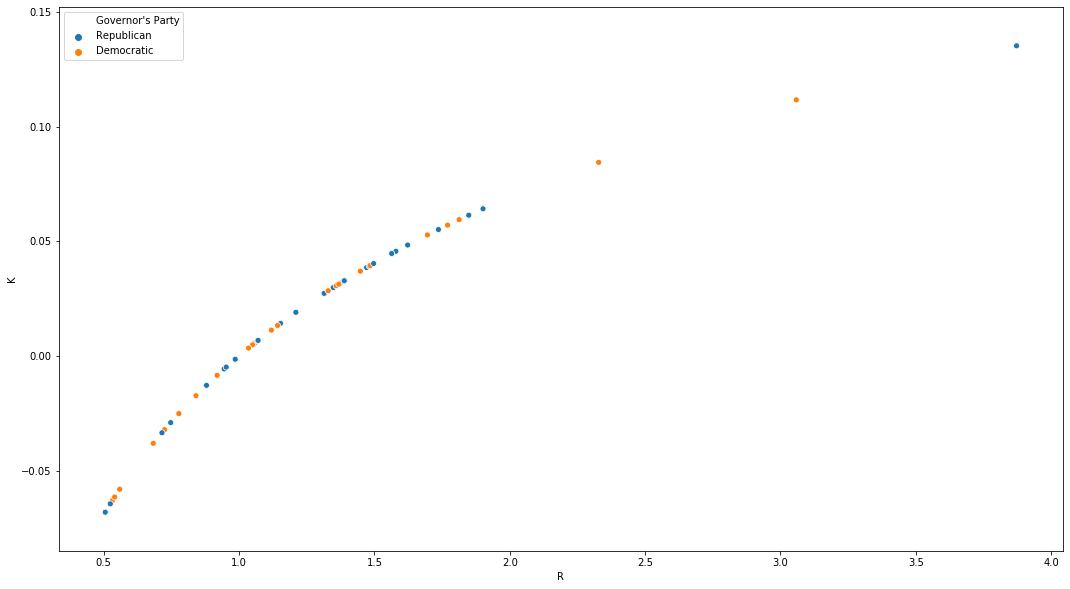

In [44]:
fig,ax = plt.subplots(figsize=(18,10))

g=sns.scatterplot(x = "R", y="K", hue= "Governor's Party", data = data)

In [45]:
#this take a minute to run
county_Rs = calculate_R(time_cases_df["FIPS"]).dropna()

county_Rs


,R,K
FIPS,,
66.0,0.655929,-0.042170
72.0,0.894311,-0.011170
1003.0,1.576235,0.045504
1007.0,1.363250,0.030987
1015.0,0.766084,-0.026646
1017.0,1.004304,0.000429
1055.0,0.859351,-0.015158
1069.0,1.607103,0.047443
1073.0,0.702849,-0.035261


These Rs are for the last few weeks of the outbreak. We could similarly calculate Rs over a different time period using optional parameters of the same functions.